In [1]:
!pip install kaggle

In [2]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json

token = {"username":"ankschoubey","key":"cafbc208fee7bb89997ce1ab23ae77fa"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [4]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d arpitjain007/game-of-deep-learning-ship-datasets -p /content

game-of-deep-learning-ship-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls

game-of-deep-learning-ship-datasets.zip  sample_submission_ns2btKE.csv
images					 test_ApKoW4T.csv
__MACOSX				 train.csv
sample_data				 train.zip


In [10]:
!unzip game-of-deep-learning-ship-datasets.zip

Archive:  game-of-deep-learning-ship-datasets.zip
replace test_ApKoW4T.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test_ApKoW4T.csv        
  inflating: sample_submission_ns2btKE.csv  
  inflating: train.zip               


In [11]:
!ls

game-of-deep-learning-ship-datasets.zip  sample_submission_ns2btKE.csv
images					 test_ApKoW4T.csv
__MACOSX				 train.csv
sample_data				 train.zip


In [12]:
!unzip train.zip

Archive:  train.zip
replace images/2870091.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/2870091.jpg      
  inflating: __MACOSX/images/._2870091.jpg  
  inflating: images/2860282.jpg      
  inflating: __MACOSX/images/._2860282.jpg  
  inflating: images/2894465.jpg      
  inflating: __MACOSX/images/._2894465.jpg  
  inflating: images/2784253.jpg      
  inflating: __MACOSX/images/._2784253.jpg  
  inflating: images/2853890.jpg      
  inflating: __MACOSX/images/._2853890.jpg  
  inflating: images/2898539.jpg      
  inflating: __MACOSX/images/._2898539.jpg  
  inflating: images/644577.jpg       
  inflating: __MACOSX/images/._644577.jpg  
  inflating: images/2856056.jpg      
  inflating: __MACOSX/images/._2856056.jpg  
  inflating: images/2792357.jpg      
  inflating: __MACOSX/images/._2792357.jpg  
  inflating: images/2904710.jpg      
  inflating: __MACOSX/images/._2904710.jpg  
  inflating: images/2748659.jpg      
  inflating: __MACOSX/images/._2748659.jpg  


In [13]:
!ls

game-of-deep-learning-ship-datasets.zip  sample_submission_ns2btKE.csv
images					 test_ApKoW4T.csv
__MACOSX				 train.csv
sample_data				 train.zip


In [0]:
from pathlib import Path
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import pandas as pd

In [0]:
path = Path('.')

In [16]:
train_csv = pd.read_csv(path/'train.csv'); train_csv.head()

image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2

In [0]:
data = (ImageList.from_df(train_csv, path=path, folder='images/')
       .split_by_rand_pct(0.2)
       .label_from_df()
       .transform(tfms = get_transforms(), size=(150,210))
       .databunch()).normalize(imagenet_stats)

In [0]:
data = ImageDataBunch.from_df('images', train_csv,size=(50*4,70*4), ds_tfms=get_transforms(), padding_mode='reflection',num_workers=2).normalize(imagenet_stats)


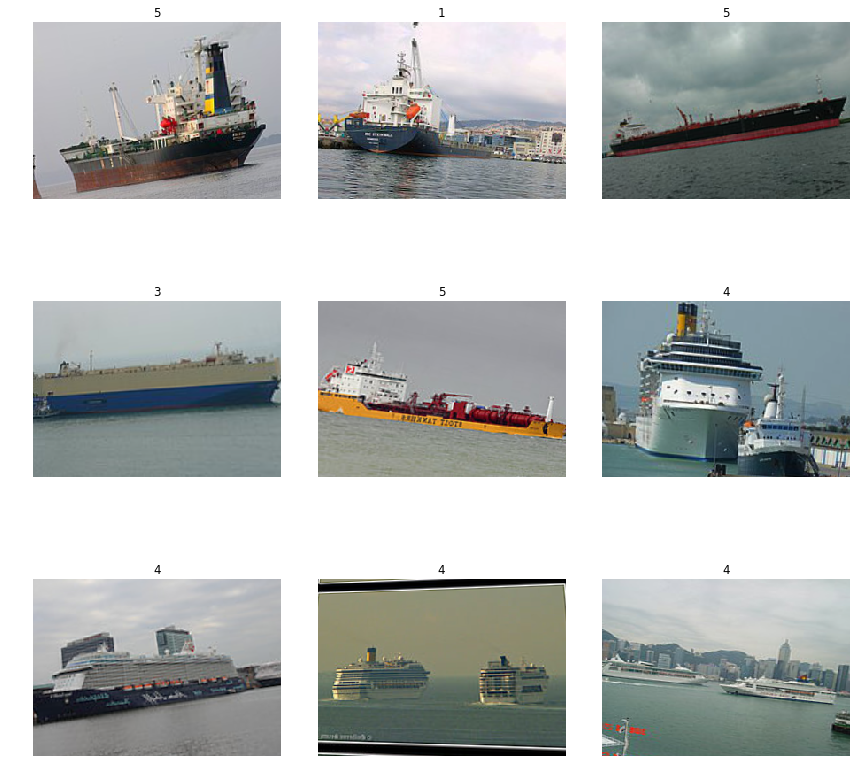

In [19]:
data.show_batch(rows=3)

# Creating Simple Fastai resnet34 with Adaptive Pooling + FC layers

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], path='.')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 93326093.25it/s]


In [0]:
learn.model

In [0]:
test_file = 'test_ApKoW4T.csv'

In [39]:
test_df = pd.read_csv(test_file)
test_df.head()

image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg

In [0]:
data = ImageList.from_df(df=test_df,path=path, folder='images/')

In [42]:
learn = load_learner()

TypeError: ignored

In [0]:
learn.summary()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


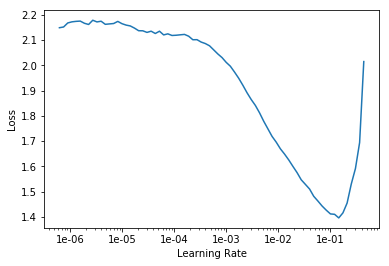

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=1e-3)

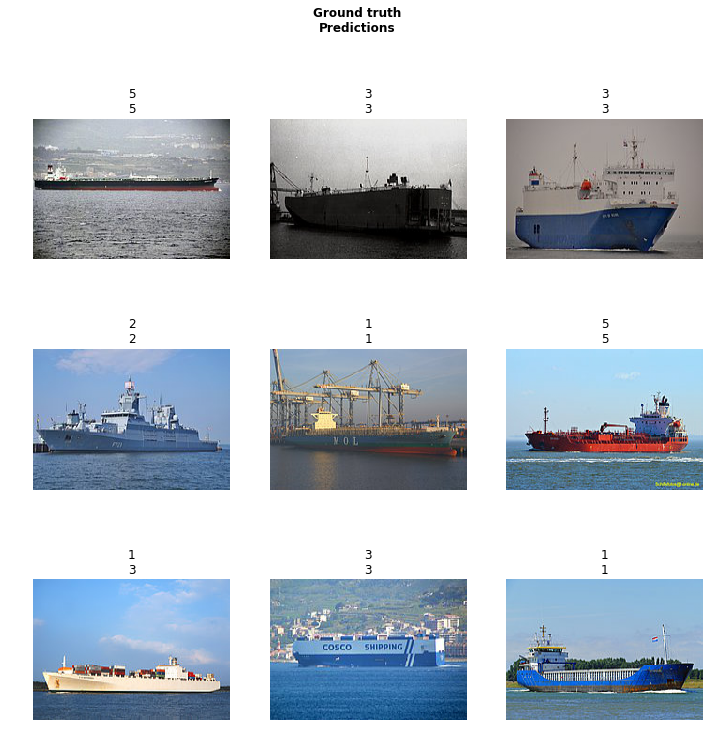

In [0]:
learn.show_results(rows=3)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


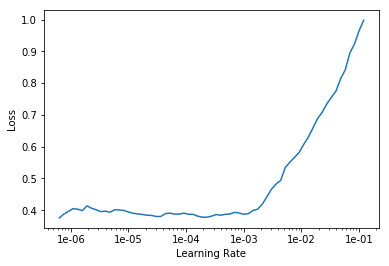

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr = slice(1e-6, 1e-4))

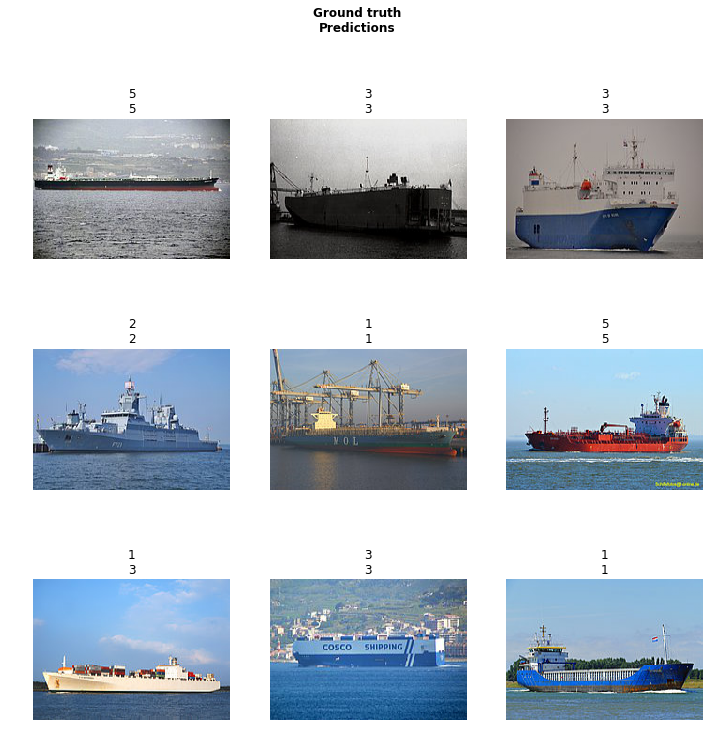

In [0]:
learn.show_results(rows=3)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idx = interp.top_losses()

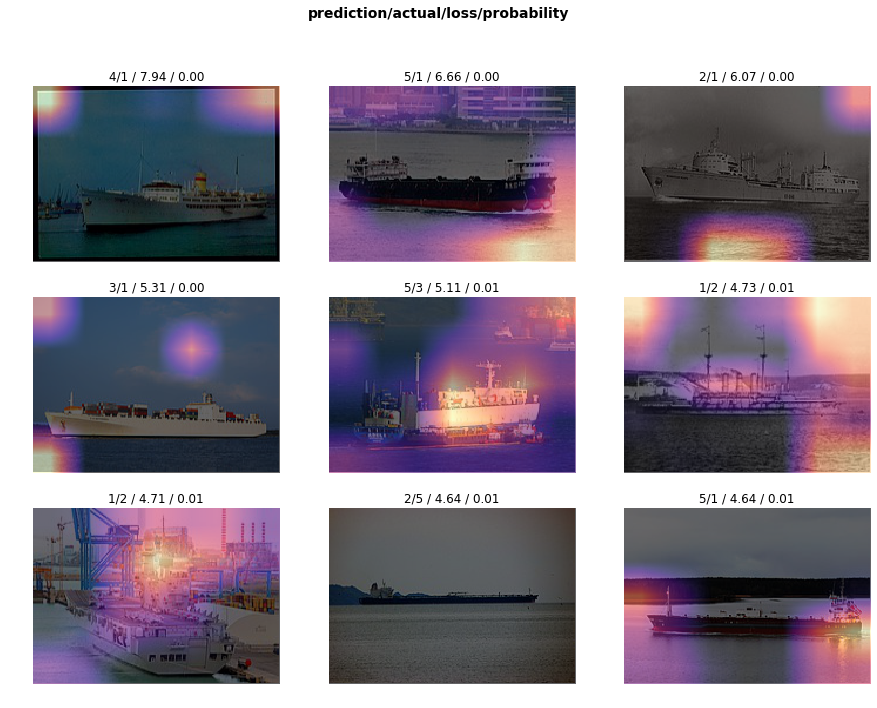

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

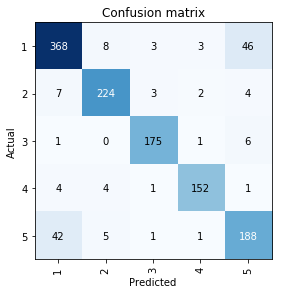

In [0]:
interp.plot_confusion_matrix()

In [0]:
import seaborn as sns

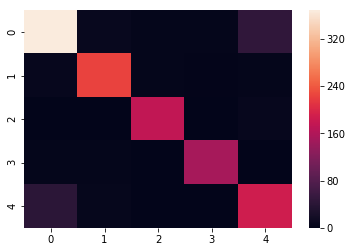

In [0]:
sns.heatmap(interp.confusion_matrix())

In [0]:
import torch
import torch.nn as nn
import torch.functional as F

# Simple FCN Head

In [0]:
class FCNHead(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.nc = nc
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=5, kernel_size=(3,3), stride=1, padding=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return torch.mean(x, (2,3))

In [0]:
head = FCNHead(5)

In [0]:
# Keeping everything (data) same as before, just changing the model
learn = cnn_learner(data, models.resnet34, custom_head = head, metrics=[error_rate, accuracy], path='.')

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 53]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
ReLU                 [64, 38, 53]         0          False     
______________________________________________________________

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


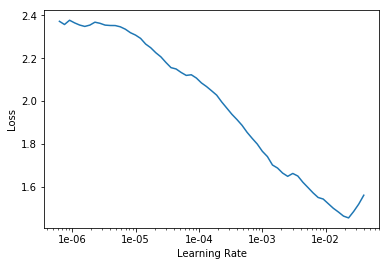

In [0]:
learn.recorder.plot()

In [0]:
# Using same learning rate and same number of epochs
learn.fit_one_cycle(3, max_lr=1e-3)

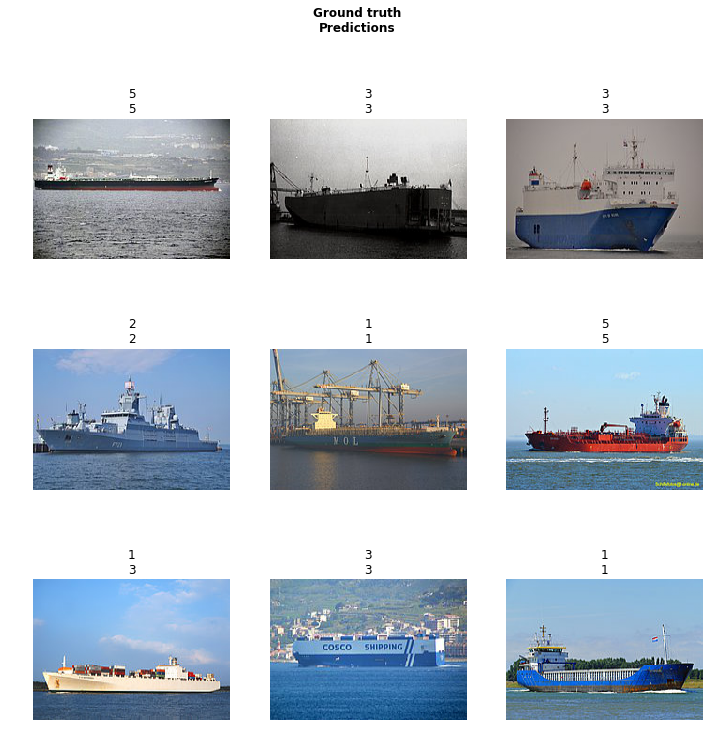

In [0]:
learn.show_results(rows=3)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


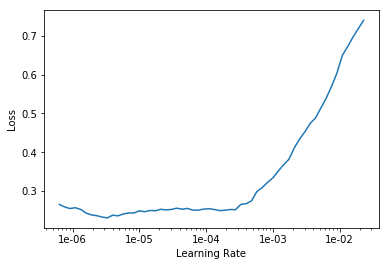

In [0]:
learn.recorder.plot()

In [0]:
# Using same learning rate and same number of epochs
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

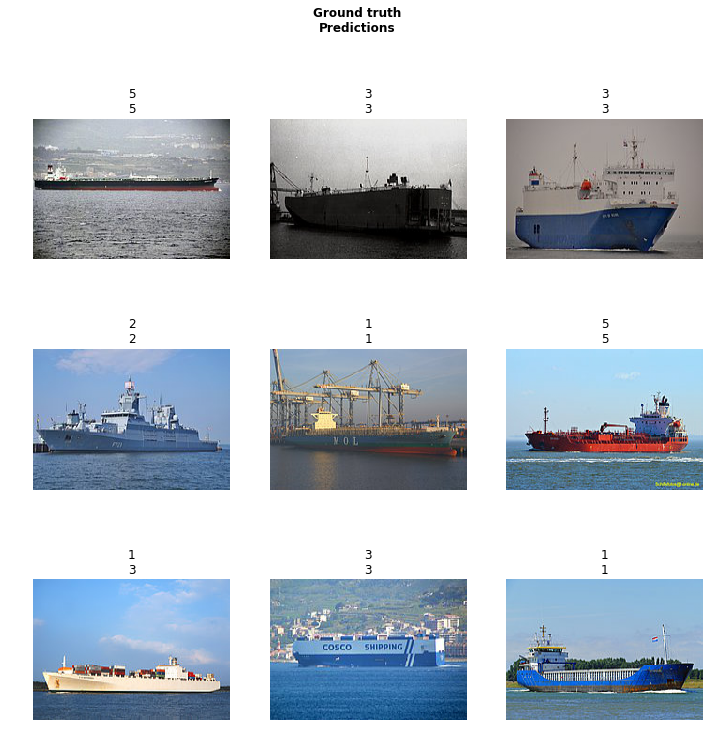

In [0]:
learn.show_results(rows=3)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idx = interp.top_losses()

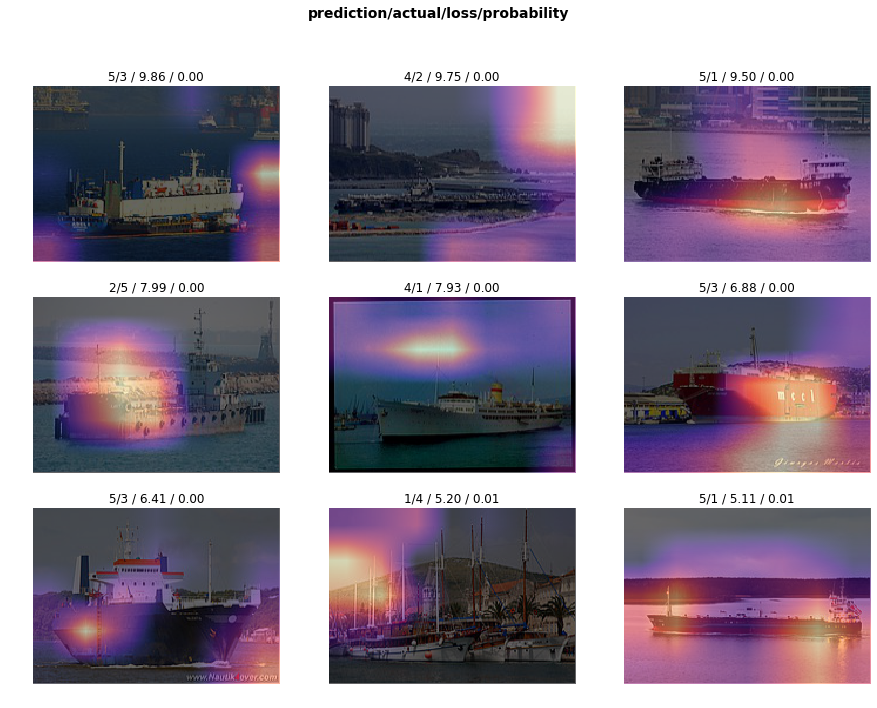

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

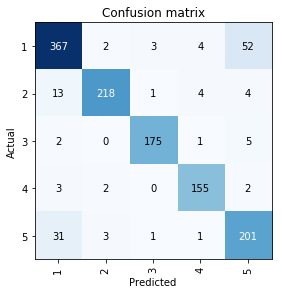

In [0]:
interp.plot_confusion_matrix()

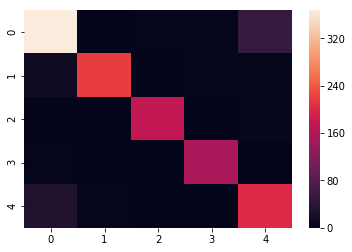

In [0]:
sns.heatmap(interp.confusion_matrix())

# Slightly improved FCN Head with BatchNorm and DropOut

In [0]:
class ImprovedFCNHead(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.nc = nc
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1)
        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm2d(num_features=256)
        self.dp = nn.Dropout()
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=5, kernel_size=(3,3), stride=1, padding=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.bn(x)
        x = self.dp(x)
        x = self.conv2(x)
        return torch.mean(x, (2,3))

In [0]:
head = ImprovedFCNHead(5)

In [0]:
# Keeping everything (data) same as before, just changing the model
learn = cnn_learner(data, models.resnet34, custom_head=head, metrics=[error_rate, accuracy], path='.')

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 53]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
ReLU                 [64, 38, 53]         0          False     
______________________________________________________________

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


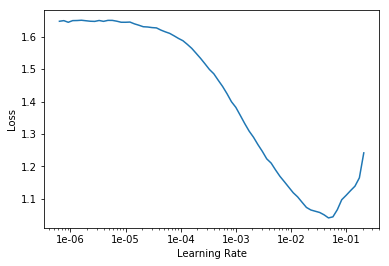

In [0]:
learn.recorder.plot()

In [0]:
# Using same learning rate and same number of epochs
learn.fit_one_cycle(3, max_lr=1e-3)

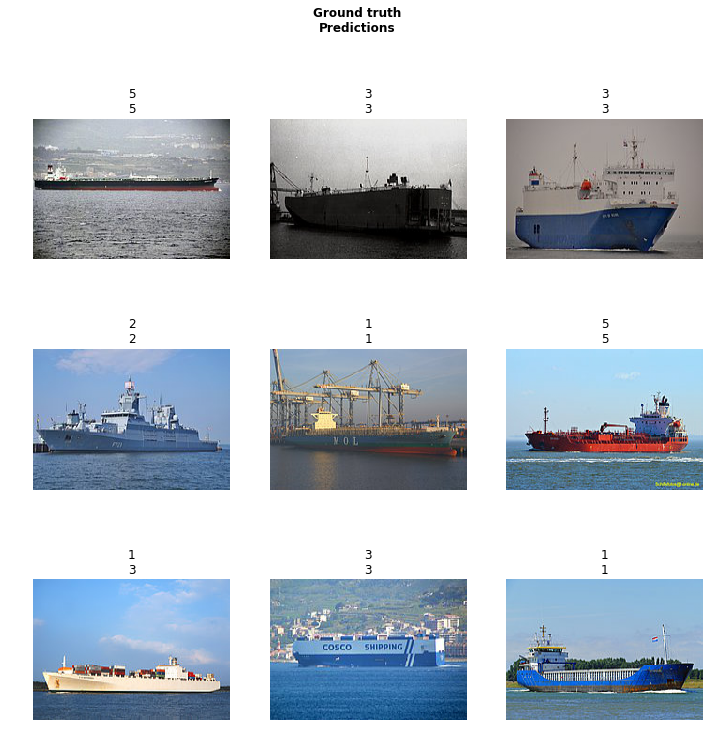

In [0]:
learn.show_results(rows=3)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


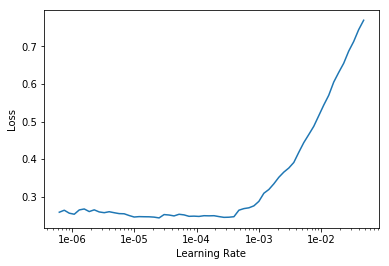

In [0]:
learn.recorder.plot()

In [0]:
# Using same learning rate and same number of epochs
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

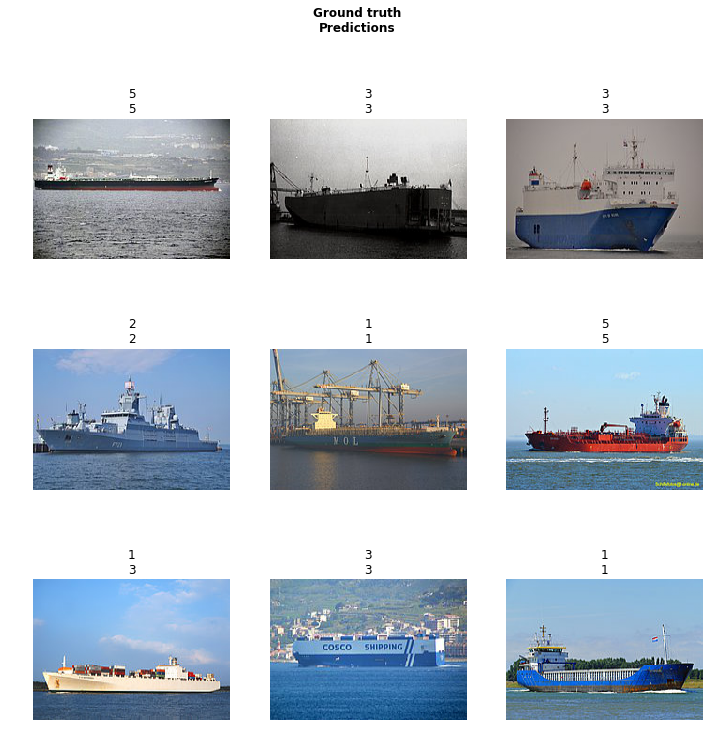

In [0]:
learn.show_results(rows=3)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idx = interp.top_losses()

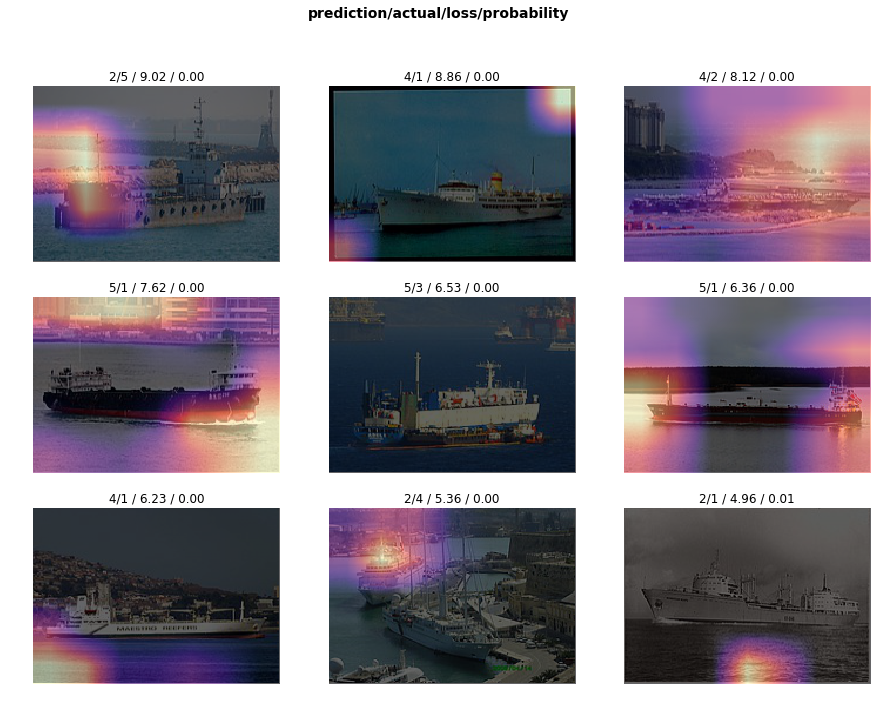

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

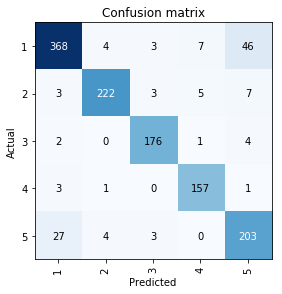

In [0]:
interp.plot_confusion_matrix()

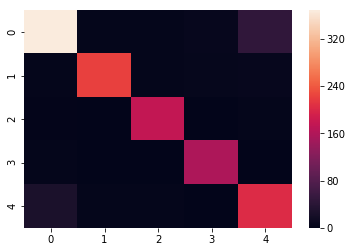

In [0]:
sns.heatmap(interp.confusion_matrix())